<a href="https://colab.research.google.com/github/Mulac/TDA-SentimentAnalysis/blob/master/BagOfWords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code altered from
https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/natural_language_processing/example_text_classification.ipynb <br>
**Add the Tweets.csv to the files section on the left**

In [26]:
!pip install lime

In [27]:
# Data
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Explainer
from lime import lime_text

# sklearn functions for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Prepare Data
Load the data from a csv into a pandas dataframe

In [28]:
dtf = pd.read_csv("Tweets.csv")
dtf.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- A bar chart to show the number of tweets for the different airlines

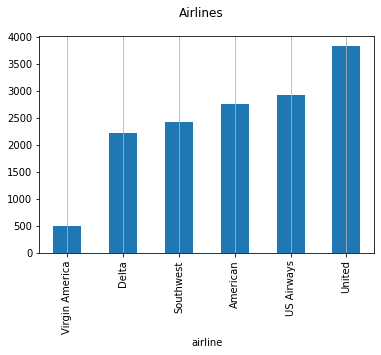

In [29]:
fig, ax = plt.subplots()
fig.suptitle("Airlines", fontsize=12)
dtf["airline"].reset_index().groupby("airline").count().sort_values(by="index").plot(kind="bar", legend=False, ax=ax).grid(axis='x')
plt.show()

- Filtering the data to only include the sentiment and the tweets text

In [30]:
# Filter for the sentiment and text
dtf = dtf[["airline_sentiment","text"]]

# Rename output to y
dtf = dtf.rename(columns={"airline_sentiment":"y"})
dtf.sample(5)

,y,text
11900,negative,@AmericanAir your planes made me miss 2 connec...
10925,negative,.@USAirways You'll be receiving a long &amp; d...
12344,negative,@AmericanAir Customer service provides no wigg...
5906,negative,@SouthwestAir Yes I can. But you guys should g...
5136,negative,@SouthwestAir 9 hours at this airport and you ...


- The following bar chart shows the distribution of the different sentiment values.
- There are far more negative tweets leading to an imbalanced dataset.
- This could make the model predict a high percentage of false negatives
- A possible solution is to duplicate random neutral and positive tweets to create an even distibution 

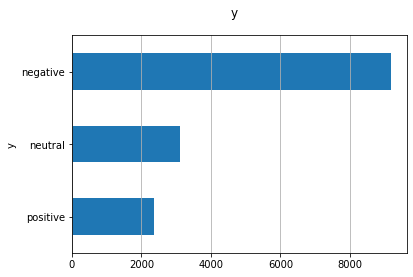

In [31]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

# Preprocessing
The function below preprocesses the tweets by doing the following:
1. CLEAN - converting the text to lowercase and remove punctuation
2. TOKENISE - convert string to a list of words
3. STOPWORDS - remove stopwords if set to true
4. STEMMING - removes suffixes if set to true
5. LEMMATISATION - convert to root word if set to true



In [32]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

  #Clean
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  #Tokenise
  lst_text = text.split()

  #remove Stopwords
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords]

  #Stemming
  if flg_stemm:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]

  #Lemmatisation
  if flg_lemm:
    lem=nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]

  #rejoin the string
  text = " ".join(lst_text)
  return text


The list of stopwords is from the natural language toolkit

In [33]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [34]:
dtf["text_clean"] = dtf["text"].apply(lambda x: preprocess_text(x, flg_lemm=True, lst_stopwords=lst_stopwords))
dtf.sample(5)

,y,text,text_clean
5333,neutral,@SouthwestAir I DM'd you,southwestair dmd
491,positive,@VirginAmerica thanks! Y'all have some of the ...,virginamerica thanks yall best customer servic...
13503,neutral,"@AmericanAir Sorry, what equipment? Have the p...",americanair sorry equipment passenger allowed ...
13842,negative,"@AmericanAir is the new @SpiritAirlines, and b...",americanair new spiritairlines worse taking gr...
5512,positive,@SouthwestAir I'll have to drop by next time I...,southwestair ill drop next time visit


The data is split into training and test data with a 70-30 split

In [35]:
# split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

# get output
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values


# Bag of Words
- using **term frequency-inverse document frequency** (Tf-Idf) to find the values of words in the tweet
 - unigrams and bigrams are included in the model
- The vocabulary orginally has 10,000 features
- The number of features is then reduced
  - key features are determined using a chi-squared test



In [36]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [37]:
corpus = dtf_train["text_clean"]

In [38]:
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [39]:
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.85
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()
print(len(X_names))

1826


- The following cell shows the top features for each of the sentiments

In [40]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# negative:
  . selected features: 852
  . top features: thank,thanks,jetblue,hour,great,southwestair,fleek,united thank,virginamerica,fleet fleek
 
# neutral:
  . selected features: 873
  . top features: fleek,jetblue fleet,fleet fleek,fleet,dm,jetblue,hi,hour,customer,destinationdragons
 
# positive:
  . selected features: 776
  . top features: awesome,great,jetblue thank,jetblue thanks,thank,thanks,united thank,amazing,love,southwestair thank
 


# neutral:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


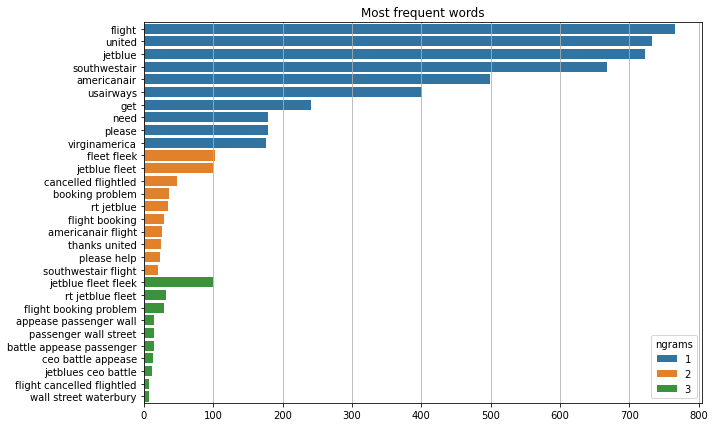

# positive:


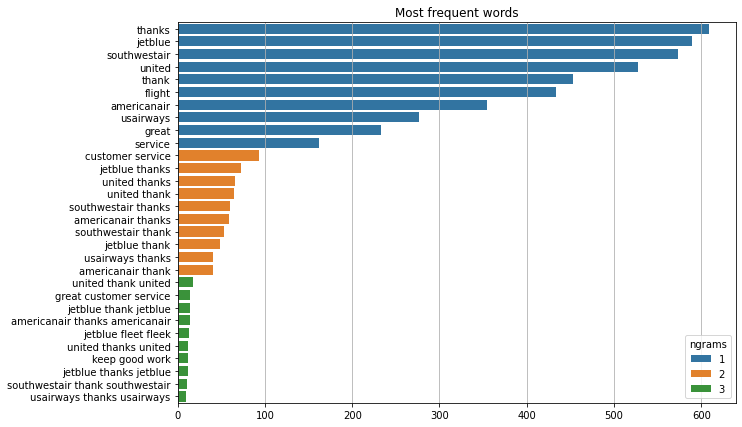

# negative:


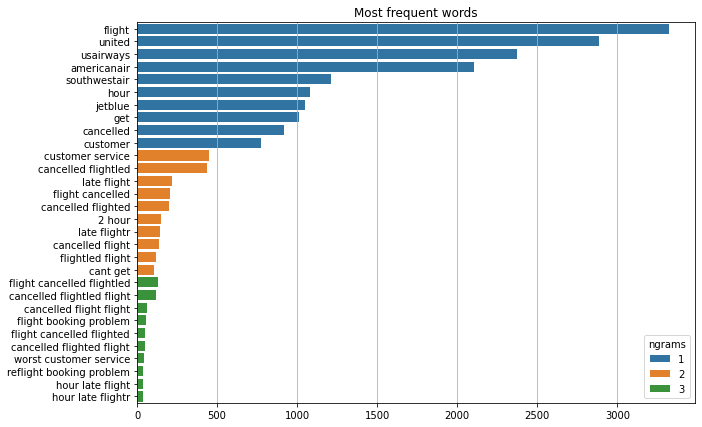

In [41]:
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

dtf_freq = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

# Naive Bayes Classifier
 - The Naive Bayes algorithm considers each feeature independently and calculates the probability of each category
 - The classifier is trained on the feature matrix
 - A pipeline is used so the vectoriser and classfier can be done in one step

In [42]:
classifier = naive_bayes.MultinomialNB()

In [43]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

# Model Performance
The following graphs and statistics for the model are computed
- Accuracy
- Confusion Matrix
- ROC: shows the true postivie rate against the false postive rate
- Precision
- Recall

Accuracy: 0.73
Auc: 0.88
Detail:
              precision    recall  f1-score   support

    negative       0.71      0.99      0.83      2766
     neutral       0.83      0.20      0.32       933
    positive       0.89      0.37      0.52       693

    accuracy                           0.73      4392
   macro avg       0.81      0.52      0.56      4392
weighted avg       0.76      0.73      0.67      4392



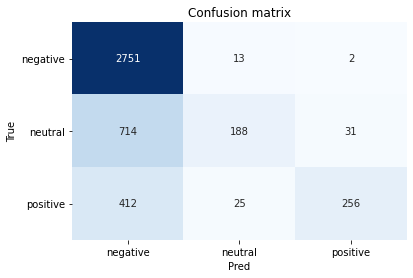

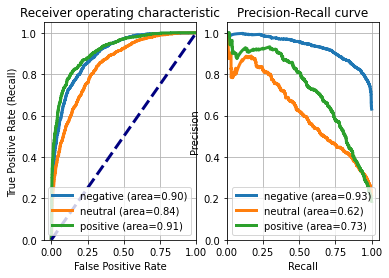

In [44]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Explainabilty
- The lime package allows us the assess the explainabilty of the predictions
- A random observation from the test set is chosen and we see what and why the model predicts the result


In [48]:
## select observation
i = np.random.randint(100)
txt_instance = dtf_test["text"].iloc[i]## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: neutral --> Pred: negative | Prob: 0.62


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
